In [1]:
import os
import random
import numpy as np
import torch

# Please make sure you are using CUDA enabled GPU for this project
device = 'cuda'

# Setting the seed value ensures that the results are reproducible across different runs
seed_val = 10

# Ensuring that the seed is set for Python's hashing, random operations, NumPy, and PyTorch
os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

folder = "data/activations"

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Getting the model from params and loading it to the GPU
# Since we will be using the same model for other notebooks, we will save it in the cache directory
model = AutoModelForCausalLM.from_pretrained(
        "google/gemma-2-2b",
        device_map='cuda:0',
        torch_dtype=torch.float16
    ).to('cuda:0')

generation_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/home/mpapucci/probabilistic-neural-network/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
import json
with open(f'{folder}/generations_and_judgments_with_sae_20.json') as input_file:
    sequences_for_few_shot_prompt = json.loads(input_file.read())

In [4]:
no_keys = [sequences_for_few_shot_prompt[key] for key in sequences_for_few_shot_prompt]

In [5]:
# Selecting a subset of sequences for few-shot prompts
subset_of_sequences_for_few_shot_prompt = no_keys[-10:]
number_of_few_shot_samples = 5

In [6]:
# Creating template for the few-shot prompt
prompt_template = 'Question: {} \n Here are some ideas that were brainstormed:{}\n Possible answer:{}\n Is the possible answer:\n (A) True\n (B) False\n The possible answer is:'
few_shot_prompt = ''


# Iterating through the subset of sequences to create the few-shot prompt
for sequence in subset_of_sequences_for_few_shot_prompt[:3]:
    question_text = sequence['prompt']
    question_text = question_text.split('Question: ')[-1].split('Answer: ')[0]
    generated_ideas = '\n'.join(sequence['generations'])
    most_probable_answer = sequence['most_probable_answer']
    is_correct = ' True' if sequence['most_probable_answer_label'][0] == 'yes' else ' False'
    
    # Appending the formatted prompt to the few_shot_prompt
    few_shot_prompt += prompt_template.format(question_text, generated_ideas, most_probable_answer) + is_correct + '\n'
#

In [7]:
from sklearn import metrics
from tqdm import tqdm

# Ensure that no gradients are computed during this block, for efficiency
with torch.no_grad():

    # Lists to store Area Under the Receiver Operating Characteristic (AUROC) values, probabilities of true, and correctness flags
    probabilities_true = []
    correctness_flags = []
    index = 0
    # Loop through the responses to compute the negative log likelihoods
    for response in tqdm(no_keys[:800]):
        question_text = response['prompt']

        # Extract generated texts and the most likely answer
        generated_ideas = '\n'.join(response['generations'])
        most_probable_answer = response['most_probable_answer']
        
        # Determine if the answer is correct based on the Judge 
        is_correct = 1.0 if response['most_probable_answer_label'] == 'yes' else 0.0

        # Construct the base and true prompts
        base_prompt_text = prompt_template.format(question_text, generated_ideas, most_probable_answer)
        prompt_with_true_answer = few_shot_prompt + prompt_template.format(question_text, generated_ideas, most_probable_answer) + ' True'

        # This computation of the negative log likelihoods follows this tutorial:   
        # Tokenize the prompts for the model
        tokenized_base_prompt = generation_tokenizer(base_prompt_text)['input_ids']
        tokenized_prompt_with_true_answer = torch.tensor(generation_tokenizer(prompt_with_true_answer)['input_ids'], device=device)

        # Prepare target IDs for the model
        target_ids_with_true_answer = tokenized_prompt_with_true_answer.clone()
        target_ids_with_true_answer[:len(tokenized_base_prompt)] = -100

        # Compute the model's output and loss for the true prompt
        model_output_with_true_answer = model(torch.reshape(tokenized_prompt_with_true_answer, (1, -1)), labels=target_ids_with_true_answer)
        loss_with_true_answer = model_output_with_true_answer.loss

        # Append the computed values to the lists
        probabilities_true.append(loss_with_true_answer.item())
        correctness_flags.append(is_correct)
        
    probabilities_true = torch.exp(-torch.tensor(probabilities_true)) 
    # Compute the AUROC for the probabilities of true
    
    auroc_for_true = metrics.roc_auc_score(1 - torch.tensor(correctness_flags), probabilities_true)


100%|██████████| 800/800 [01:14<00:00, 10.73it/s]


In [10]:
auroc_for_true

0.5225725132198182

/tmp/ipykernel_12860/2598049551.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probabilities_true_tensor = torch.tensor(probabilities_true)


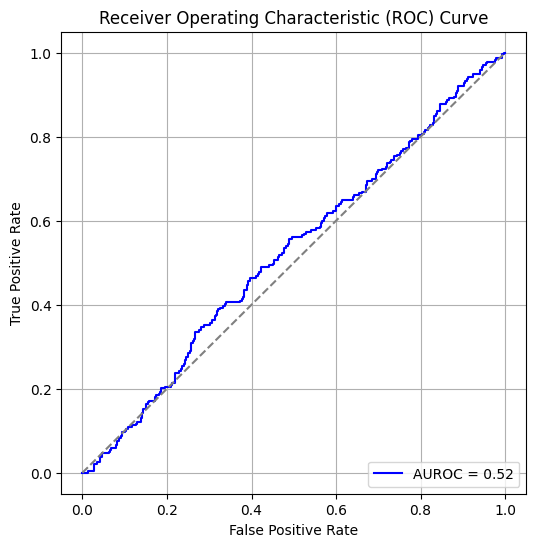

In [9]:
import torch
import matplotlib.pyplot as plt
from sklearn import metrics

# Convert lists to tensors
correctness_flags_tensor = torch.tensor(correctness_flags)
probabilities_true_tensor = torch.tensor(probabilities_true)

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, _ = metrics.roc_curve(1 - correctness_flags_tensor.numpy(), probabilities_true_tensor.numpy())
auroc = metrics.auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
